In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
from scipy import misc
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

Загружаем данные и исправляем ошибку с hero_id

In [67]:
matches = pd.read_csv("data/match.csv")
players = pd.read_csv("data/players.csv")
players['hero_id'] = players['hero_id'] + 1
players.loc[players['hero_id'] == 24, 'hero_id'] = 25
heroes = pd.read_csv("data/hero_names.csv")
items = pd.read_csv("data/item_ids.csv")

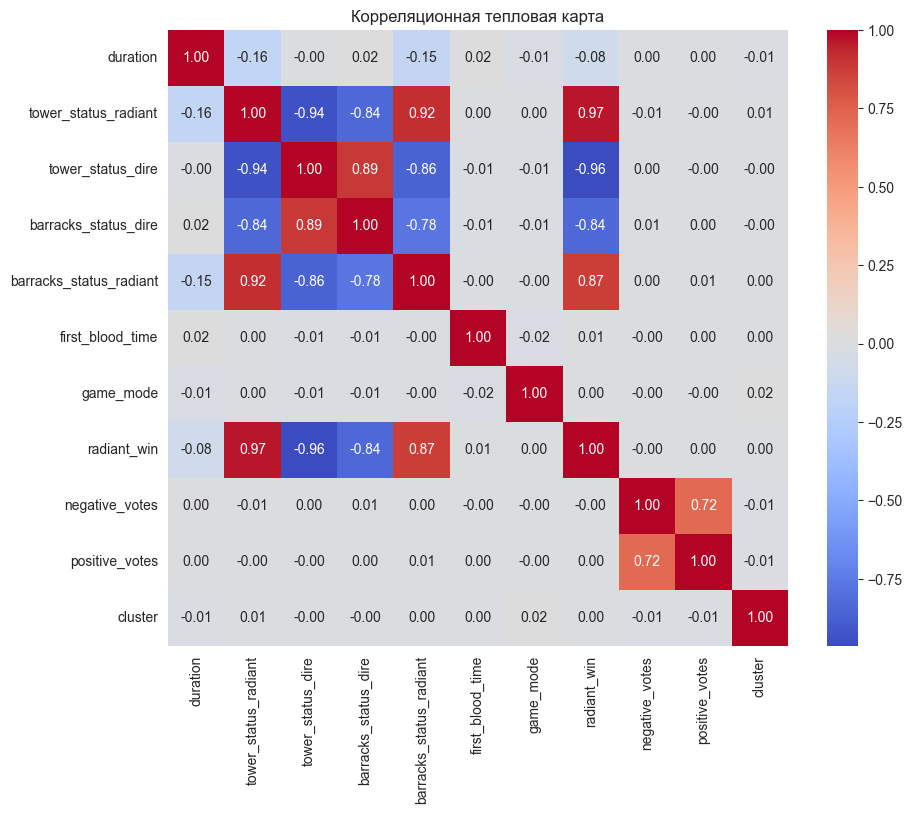

In [68]:
matches_corr = matches.copy()
matches_corr.drop(["match_id", "start_time"], axis = 1, inplace = True)

plt.figure(figsize=(10, 8))
sns.heatmap(matches_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная тепловая карта")
plt.show()

Видим по тепловой карте, что только между связанными признаки есть корреляция

Выделяем целевую переменную: radiant_win - победа команды radiant (1 - True, 0 - False)

In [69]:
y = matches['radiant_win'].apply(lambda win: 1 if win else 0)

Подготовим признаки для обучения модели. Создаем словарь имен героев и подставляем его в таблицу игроков

In [70]:
heroes_dict = dict(zip(heroes['hero_id'], heroes['localized_name']))
heroes_dict[0] = 'Unknown'
players['hero'] = players['hero_id'].apply(lambda _id: heroes_dict[_id])

In [71]:
items_dict = dict(zip(items['item_id'], items['item_name']))
items_dict[0] = 'Unknown'

Строк, в которых отсутствует хотя бы один предмет очень много, заменим их на значение Unknown

In [72]:
print(players[['item_0', 'item_1', 'item_2', 'item_3', 'item_4', 'item_5']].eq(0).any(axis=1).sum())

226889


In [73]:
def find_item(_id):
    return items_dict.get(_id, 0)

players['item_0'] = players['item_0'].apply(find_item)
players['item_1'] = players['item_1'].apply(find_item)
players['item_2'] = players['item_2'].apply(find_item)
players['item_3'] = players['item_3'].apply(find_item)
players['item_4'] = players['item_4'].apply(find_item)
players['item_5'] = players['item_5'].apply(find_item)

 Создаёт новую таблицу, в которой для каждого героя создаётся отдельный столбик с бинарным значением, обозначающий присутствие данного героя. То же самое делаем для предметов.

In [74]:
player_heroes = pd.get_dummies(players['hero'])

In [75]:
item0 = pd.get_dummies(players['item_0'].fillna(0))
item1 = pd.get_dummies(players['item_1'].fillna(0))
item2 = pd.get_dummies(players['item_2'].fillna(0))
item3 = pd.get_dummies(players['item_3'].fillna(0))
item4 = pd.get_dummies(players['item_4'].fillna(0))
item5 = pd.get_dummies(players['item_5'].fillna(0))

Так как порядок предметов в данном контексте не важен, объединяем их в одну таблицу, складывая значения

In [76]:
player_items = item0.add(item1, fill_value=0).add(item2, fill_value=0).add(item3, fill_value=0).add(item4, fill_value=0).add(item5, fill_value=0)

Подготавливаем колонки для игроков и предметов команды radiant и dire

In [77]:
radiant_players_cols = list(map(lambda s: 'radiant_' + s, player_heroes.columns.values))
dire_players_cols = list(map(lambda s: 'dire_' + s, player_heroes.columns.values))

radiant_items_cols = list(map(lambda s: 'radiant_' + str(s), player_items.columns.values))
dire_items_cols = list(map(lambda s: 'dire_' + str(s), player_items.columns.values))

Группируем данные по матчам и создаем признаки для команд radiant и dire, складывая первые 5 строк для radiant, а следующие 5 для dire

In [78]:
# X = None
# radiant_heroes = []
# dire_heroes = []
# radiant_items = []
# dire_items = []
# 
# for _id, _index in players.groupby('match_id').groups.items():
#     radiant_heroes.append(player_heroes.iloc[_index][:5].sum().values)
#     dire_heroes.append(player_heroes.iloc[_index][5:].sum().values)
#     radiant_items.append(player_items.iloc[_index][:5].sum().values)
#     dire_items.append(player_items.iloc[_index][5:].sum().values)

In [79]:
# radiant_heroes = pd.DataFrame(radiant_heroes, columns=radiant_players_cols)
# dire_heroes = pd.DataFrame(dire_heroes, columns=dire_players_cols)
# radiant_items = pd.DataFrame(radiant_items, columns=radiant_items_cols)
# dire_items = pd.DataFrame(dire_items, columns=dire_items_cols)
# X = pd.concat([radiant_heroes, radiant_items, dire_heroes, dire_items], axis=1)

Формируем объединенный набор признаков для каждого матча, описывающий количество предметов и героев для каждой из команд

In [80]:
# X.to_csv('mapped_match_hero_item.csv', index=False)

In [81]:
X = pd.read_csv('mapped_match_hero_item.csv')

In [82]:
X

,radiant_Abaddon,radiant_Alchemist,radiant_Ancient Apparition,radiant_Anti-Mage,radiant_Axe,radiant_Bane,radiant_Batrider,radiant_Beastmaster,radiant_Bloodseeker,radiant_Bounty Hunter,...,dire_vanguard,dire_veil_of_discord,dire_vitality_booster,dire_vladmir,dire_void_stone,dire_ward_dispenser,dire_ward_observer,dire_ward_sentry,dire_wraith_band,dire_yasha
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,2,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
49997,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [83]:
X.shape

(50000, 524)

Перемешиваем данные для изменения порядка

In [84]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=42)

Разделяем X и y на обучающий и тестовый наборы

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Обучем модель логистической регрессии

In [86]:
model =  LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(max_iter=500)

Производим предсказание на тестовом наборе и выводим метрики

In [87]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4820
           1       0.97      0.97      0.97      5180

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Смотрим матрицу ошибок

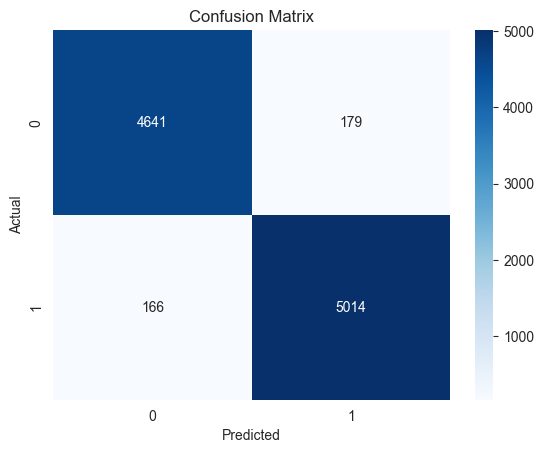

In [88]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, xticklabels=['0', '1'], yticklabels=['0', '1'], annot=True, fmt="d", cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [89]:
train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"AUC на обучении: {train_auc:.4f}")
print(f"AUC на тесте: {test_auc:.4f}")

AUC на обучении: 0.9962
AUC на тесте: 0.9950


In [90]:
scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f"AUC на кросс-валидации: {scores.mean():.4f}")

AUC на кросс-валидации: 0.9949


AUC на обучении, тесте и кросс-валидации имеют высокие, близкие друг к другу, значения, что говорит о хорошей обобщающей способности модели и минимальном переобучении.

Выводим 10 признаков с наибольшими коэффициентами логистической регрессии, которые отражают влияние признаков на вероятность положительного класса

In [92]:
coefficients = pd.DataFrame({'Coefficient': model.coef_[0], 'Feature': X.columns})
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
top10_coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False).head(10)

print(top10_coefs)

     Coefficient                   Feature  Abs_Coefficient
114     2.359102             radiant_aegis         2.359102
309    -2.197556           dire_Lone Druid         2.197556
214     1.999230            radiant_rapier         1.999230
47      1.995395        radiant_Lone Druid         1.995395
476    -1.949107               dire_rapier         1.949107
430    -1.913889     dire_guardian_greaves         1.913889
376    -1.872355                dire_aegis         1.872355
168     1.690795  radiant_guardian_greaves         1.690795
135     1.683281         radiant_butterfly         1.683281
397    -1.658873            dire_butterfly         1.658873
